# Late Fusion adapted by Transfer Squeeze Net

We will implement late fusion which is introduced in paper "Large-scale Video Classification with Convolutional Neural Network" 

The pipeline will be described in detail as below.

First, we will clip 7 frames from a video that we want to classify. 

Second, we will pass the 7 frames individually through trained squeeze net on image net to get a 1000 result which is used in image net label.

Third, we will concatinate 7 1000 result together to train another FC layer to give the labels that we want to classify our video. 

Above all, we will implement these late fusion approach and fine tune hyperparameters to yeild the best possbile result

# load Squeeze Net model and other libraries

In [1]:
# As usual, a bit of setup
from __future__ import print_function
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import json
import random

from cs231n.classifiers.squeezenet import SqueezeNet
from cs231n.data_utils import load_tiny_imagenet
from cs231n.image_utils import preprocess_image, deprocess_image
from cs231n.image_utils import SQUEEZENET_MEAN, SQUEEZENET_STD


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def get_session():
    """Create a session that dynamically allocates memory."""
    # See: https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# load dataset and preprocess
 - First, run DataProprocessing Notebook to get label (Y) and data (X) txt file. 
 - Second, move label and data txt file into this notebook foler
 - third, run the code below

In [2]:
def get_data(num_training = 1560, num_validation = 200, num_test = 200):
    ''' 
    load the training data provided by Jake 
    
    '''
    # load the data
    x_total = np.load("data_7_frame.npy")
    y_total = np.load("label_7_frame.npy")
        
#     # Subsample the data index for train, test, and validation
#     train_index = np.arange(0,num_training+num_validation+num_test)
#     valid_index = random.sample(range(0, num_training+num_validation+num_test), num_validation)
#     train_index = np.delete(train_index, valid_index)
#     test_index = random.sample(range(0, num_training+num_test), num_test)
#     train_index = np.delete(train_index, test_index)
    
#     # training data
#     x_train = x_total[train_index]
#     y_train = y_total[train_index]
#     # validation data
#     x_val = x_total[valid_index]
#     y_val = y_total[valid_index]
#     # test data
#     x_test = x_total[test_index]
#     y_test = y_total[test_index]

    # Subsample the data
    # training data
    mask_train = range(0, num_training)
    x_train = x_total[mask_train]
    y_train = y_total[mask_train]
    # validation data
    mask_val = range(num_training, num_training + num_validation)
    x_val = x_total[mask_val]
    y_val = y_total[mask_val]
    # test data
    mask_test = range(num_training+num_validation, num_training+num_validation+num_test)
    x_test = x_total[mask_test]
    y_test = y_total[mask_test]
    
    # normalize the data: subtract the mean
    mean_video = np.floor(np.mean(x_train, axis=0))
    x_train = x_train - mean_video
    x_val = x_val - mean_video
    x_test = x_test - mean_video
    
    return x_train, y_train, x_val, y_val, x_test, y_test

x_train, y_train, x_val, y_val, x_test, y_test = get_data()

print('Train data shape: ', x_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', x_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (1560, 7, 224, 224, 3)
Train labels shape:  (1560,)
Validation data shape:  (200, 7, 224, 224, 3)
Validation labels shape:  (200,)
Test data shape:  (200, 7, 224, 224, 3)
Test labels shape:  (200,)


# define to train the last layer

In [3]:
def my_model(rg, lr, dr, dc, FC_size):
    tf.reset_default_graph()
    sess = get_session()
    SAVE_PATH = 'cs231n/datasets/squeezenet.ckpt'
    model = SqueezeNet(save_path=SAVE_PATH, sess=sess)
    
    regularizers = 0
    NUM_CLASSES = 4 
    with tf.variable_scope('classifier_squeeze_frame'):
        with tf.variable_scope('layer0'):
            FRAME_PER_VIDEO = tf.constant(7, dtype='int32')
            x = model.features
            dims = tf.shape(x)
            N,H,W,C = dims[0], dims[1], dims[2], dims[3]
            x = tf.reshape(x, [tf.to_int32(N/FRAME_PER_VIDEO), H*W*C*FRAME_PER_VIDEO]) 
            W1 = tf.get_variable("weights1",shape=[605696,FC_size])
            b1 = tf.get_variable("bias1",shape=[FC_size])
            x = tf.matmul(x,W1)+b1
            regularizers += tf.nn.l2_loss(W1)
            W2 = tf.get_variable("weights2",shape=[FC_size,NUM_CLASSES])
            b2 = tf.get_variable("bias2",shape=[NUM_CLASSES])
            x = tf.matmul(x,W2)+b2
            regularizers += tf.nn.l2_loss(W2)
            
    model.classifier = tf.reshape(x,[-1, NUM_CLASSES])
    total_loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(model.labels, NUM_CLASSES), logits=model.classifier)
    mean_loss = tf.reduce_mean(total_loss + regularizers*rg)
    classifier_squeeze_variable = tf.contrib.framework.get_variables('classifier_squeeze_frame')
    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = lr
    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, dc, dr, staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate) # select optimizer and set learning rate
    train_step = optimizer.minimize(mean_loss, var_list = classifier_squeeze_variable)
    return sess, model, mean_loss, train_step

# define run model

In [4]:
def run_model(session, model, loss_val, Xd, yd,
              epochs=1, batch_size=40, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(model.classifier,1), model.labels)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss, correct_prediction, accuracy]
    
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            X_batch = Xd[idx,:]
            N,F,H,W,C = X_batch.shape
            X_batch_reshape = np.reshape(X_batch, [N*F,H,W,C])
            feed_dict = {model.image: X_batch_reshape,
                         model.labels: yd[idx]}
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

# train, validate, and test the model


--------------------------------------------------------------------------------
Trial number: 0
--------------------------------------------------------------------------------
reg: 0.171435, lr: 0.000003, dr: 0.848239, dc: 995, FC_size: 100 
INFO:tensorflow:Restoring parameters from cs231n/datasets/squeezenet.ckpt


INFO:tensorflow:Restoring parameters from cs231n/datasets/squeezenet.ckpt


Train
Iteration 0: with minibatch training loss = 19.5 and accuracy of 0.17
Iteration 100: with minibatch training loss = 17.5 and accuracy of 0.17
Iteration 200: with minibatch training loss = 15.2 and accuracy of 0.17
Epoch 1, Overall loss = 16.6 and accuracy of 0.306


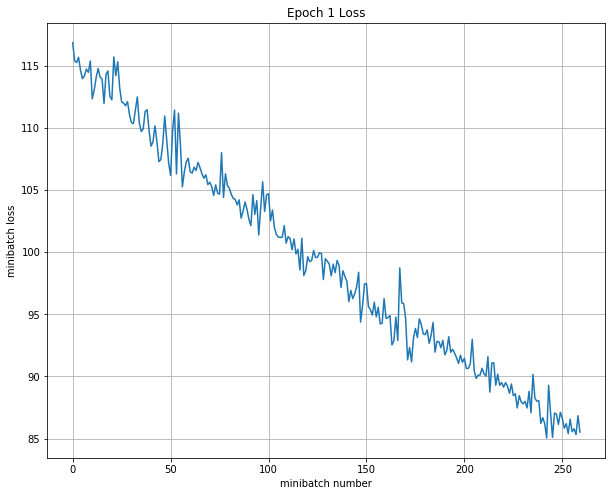

Iteration 300: with minibatch training loss = 13.5 and accuracy of 0.67
Iteration 400: with minibatch training loss = 12.5 and accuracy of 0.5
Iteration 500: with minibatch training loss = 11.3 and accuracy of 0.5
Epoch 2, Overall loss = 12.6 and accuracy of 0.346


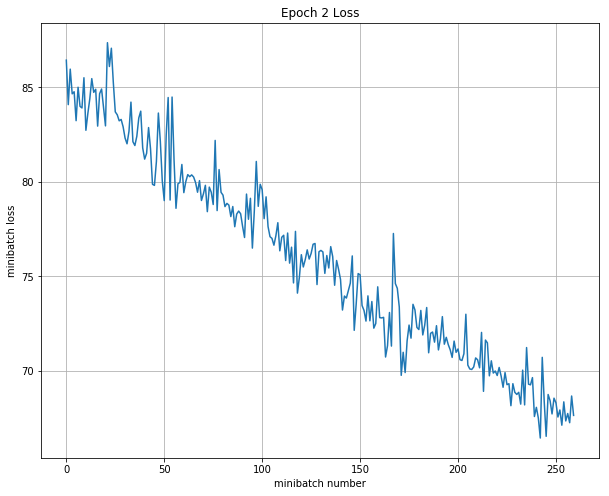

Iteration 600: with minibatch training loss = 10.6 and accuracy of 0.5
Iteration 700: with minibatch training loss = 9.89 and accuracy of 0.17
Epoch 3, Overall loss = 10.3 and accuracy of 0.363


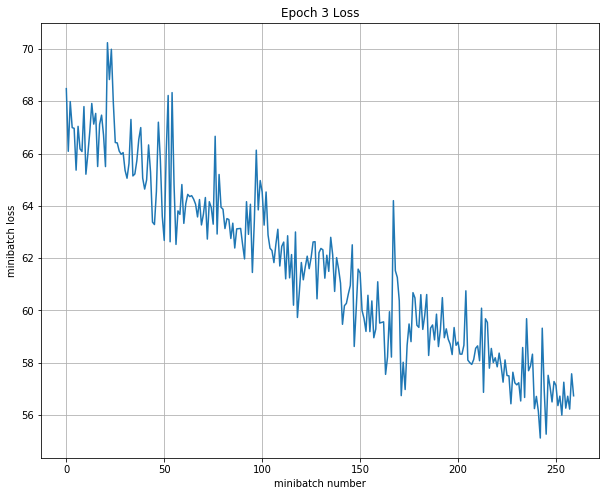

Iteration 800: with minibatch training loss = 9.14 and accuracy of 0.5
Iteration 900: with minibatch training loss = 8.83 and accuracy of 0.33
Iteration 1000: with minibatch training loss = 8.4 and accuracy of 0.67
Epoch 4, Overall loss = 8.82 and accuracy of 0.383


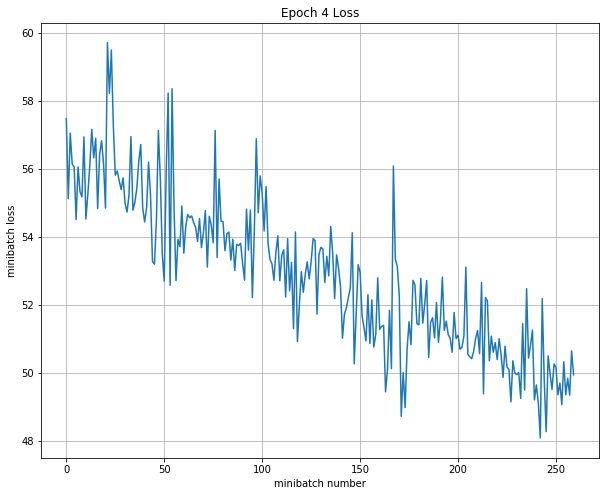

Iteration 1100: with minibatch training loss = 7.89 and accuracy of 0.67
Iteration 1200: with minibatch training loss = 7.66 and accuracy of 0.67
Epoch 5, Overall loss = 7.89 and accuracy of 0.398


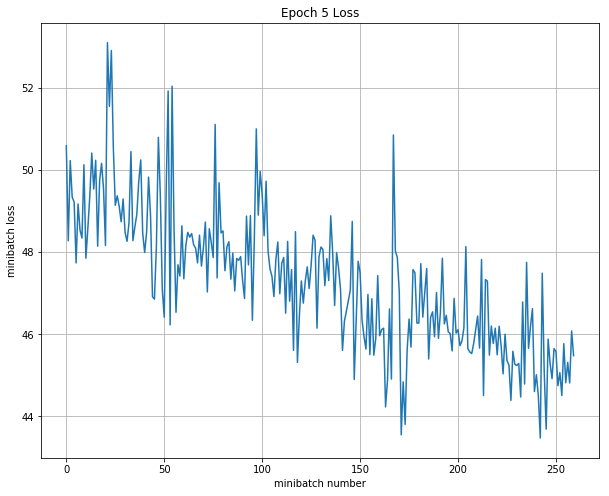

Iteration 1300: with minibatch training loss = 7.68 and accuracy of 0.17
Iteration 1400: with minibatch training loss = 7.57 and accuracy of 0.17
Iteration 1500: with minibatch training loss = 7.11 and accuracy of 0.17
Epoch 6, Overall loss = 7.25 and accuracy of 0.415


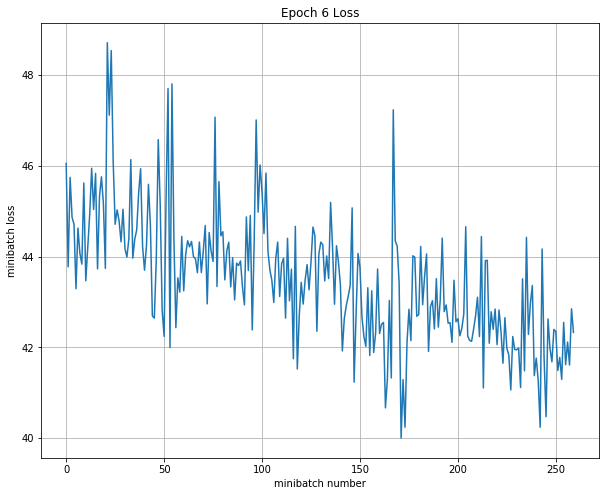

Iteration 1600: with minibatch training loss = 6.77 and accuracy of 0.67
Iteration 1700: with minibatch training loss = 6.77 and accuracy of 0.67
Iteration 1800: with minibatch training loss = 6.54 and accuracy of 0.5
Epoch 7, Overall loss = 6.78 and accuracy of 0.429


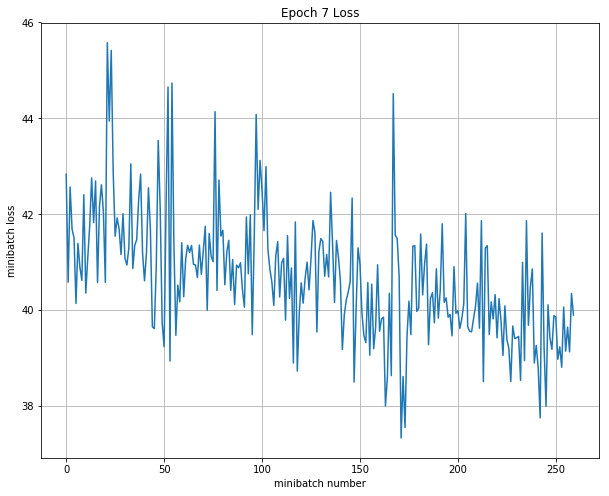

Iteration 1900: with minibatch training loss = 6.56 and accuracy of 0.5
Iteration 2000: with minibatch training loss = 6.31 and accuracy of 0.83
Epoch 8, Overall loss = 6.41 and accuracy of 0.444


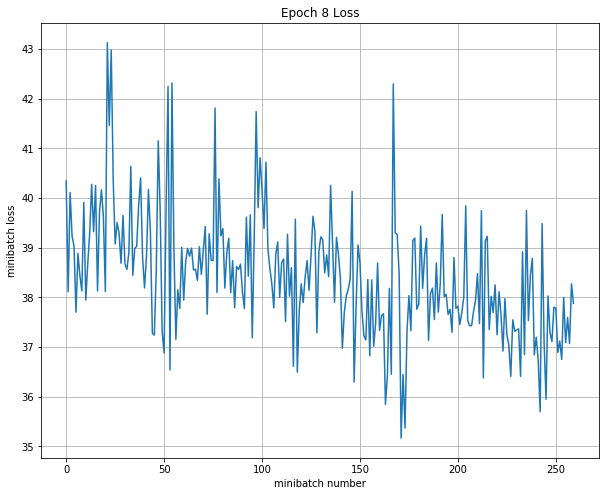

Iteration 2100: with minibatch training loss = 6.01 and accuracy of 0.5
Iteration 2200: with minibatch training loss = 6.05 and accuracy of 0.5
Iteration 2300: with minibatch training loss = 5.89 and accuracy of 0.67
Epoch 9, Overall loss = 6.09 and accuracy of 0.453


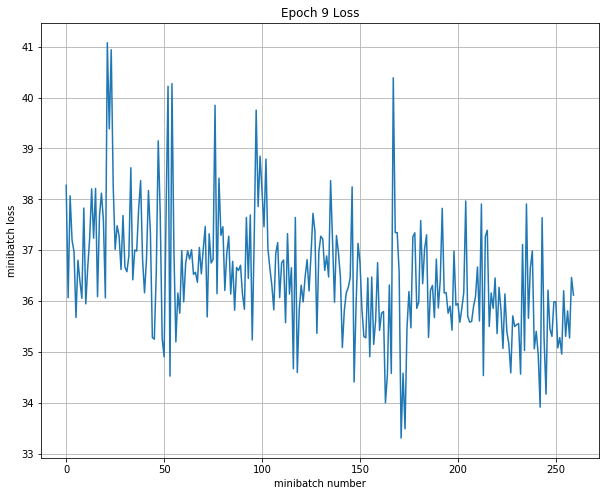

Iteration 2400: with minibatch training loss = 5.71 and accuracy of 0.67
Iteration 2500: with minibatch training loss = 5.62 and accuracy of 0.67
Epoch 10, Overall loss = 5.8 and accuracy of 0.464


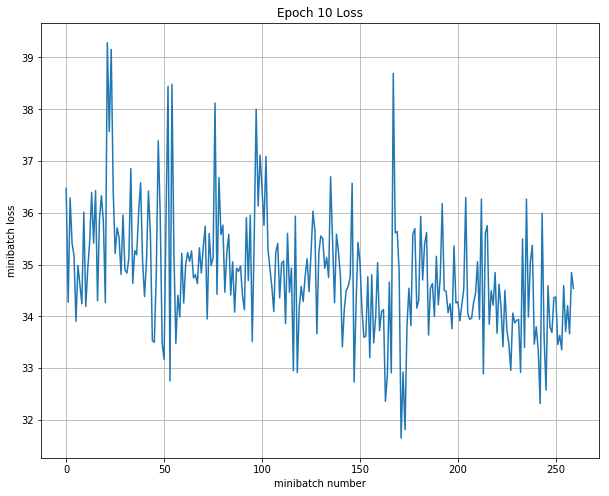

Validation


ResourceExhaustedError: OOM when allocating tensor with shape[1400,64,111,111]
	 [[Node: features/layer0/Conv2D = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="VALID", strides=[1, 2, 2, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](_arg_input_image_0_0/_137, features/layer0/weights/read)]]
	 [[Node: Mean/_145 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_412_Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'features/layer0/Conv2D', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/traitlets/config/application.py", line 592, in launch_instance
    app.start()
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 405, in start
    ioloop.IOLoop.instance().start()
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 260, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 212, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 370, in execute_request
    user_expressions, allow_stdin)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 175, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2902, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3006, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3066, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-25f433804468>", line 20, in <module>
    sess, model, mean_loss, train_step  = my_model(rg, lr, dr, dc, FC_size)
  File "<ipython-input-3-8689206a855e>", line 5, in my_model
    model = SqueezeNet(save_path=SAVE_PATH, sess=sess)
  File "/home/kongl/Project/Late Fusion/cs231n/classifiers/squeezenet.py", line 88, in __init__
    self.layers = self.extract_features(x, reuse=False)
  File "/home/kongl/Project/Late Fusion/cs231n/classifiers/squeezenet.py", line 35, in extract_features
    x = tf.nn.conv2d(x,W,[1,2,2,1],"VALID")
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 399, in conv2d
    data_format=data_format, name=name)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[1400,64,111,111]
	 [[Node: features/layer0/Conv2D = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="VALID", strides=[1, 2, 2, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](_arg_input_image_0_0/_137, features/layer0/weights/read)]]
	 [[Node: Mean/_145 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_412_Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [5]:
best_acc = 0
test_acc = 0
best_sess = None
best_hyper = None
best_model = None
best_mean_loss = None
with tf.device("/gpu:0") as dev:
    for i in range(30):
        rg = 10**np.random.uniform(-3,1) # regularization
        lr = 10**np.random.uniform(-6,-2) # learning rate
        dr = np.random.uniform(0.75,1) # decay rate
        dc = np.random.randint(500,1000) # decay cut
        FC_size = 100
        # FC_size = np.random.randint(100,150) # decay cut
        print ('')
        print ('-'*80)
        print ('Trial number: %d' %i)
        print ('-'*80)
        print ('reg: %f, lr: %f, dr: %f, dc: %d, FC_size: %d ' %(rg, lr, dr, dc, FC_size))
        sess, model, mean_loss, train_step  = my_model(rg, lr, dr, dc, FC_size)
        sess.run(tf.global_variables_initializer())
        print('Train')
        run_model(sess,model,mean_loss,x_train,y_train,10,6,100,train_step,True)
        print('Validation')
        _, val_acc = run_model(sess,model,mean_loss,x_val,y_val,1,200)
        print('Test')
        _, test_acc = run_model(sess,model,mean_loss,x_test,y_test,1,200) 
        if val_acc > best_acc:
            best_sess = sess
            best_model = model
            best_mean_loss = mean_loss
            best_acc = val_acc
            best_hyper = [rg, lr, dr, dc, FC_size] 
            test_under_best_val = test_acc
    print ('')
    print ('-'*80)
    print ('Conslusion')
    print ('-'*80)
    print ('Best hyperparam for rg, lr, dr, dc, FC_size is')
    print (best_hyper)
    print ('Best validation accuracy is %f' %best_acc)
    print ('Best test accuracy is %f' %test_under_best_val)
    

# test result

In [ ]:
print('Test')
_, test_acc = run_model(best_sess,best_model,best_mean_loss,x_test,y_test,1,200) 